In [1]:
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["gurobi"], # modules to install
    license_uuid="bb2c71f6-2b4c-4570-8eaf-4db0b0d7349a") # license to use

Licensed to Bundle #6733.7184 expiring 20241231: ICI5142-01 INVESTIGACION DE OPERACIONES AVANZADAS (Advanced Operations Research), Prof. Guillermo Cabrera-Guerrero, Pontificia Universidad Catolica de Valparaiso.


In [2]:
# Funciones para cargar datos desde archivos
def cargarArchivoCap(ruta_archivo):
    try:
        with open(ruta_archivo, 'r') as archivo:
            datos = archivo.read().split()
        num_tiendas = int(datos[0])
        num_clientes = int(datos[1])

        capacidades = []
        costos_fijos = []
        for i in range(2, num_tiendas * 2 + 2, 2):
            capacidades.append(int(datos[i]))
            costos_fijos.append(float(datos[i + 1]))

        inicio_matriz = (num_tiendas * 2) + 2
        demandas = []
        matriz_costos = []

        for i in range(inicio_matriz, inicio_matriz + (num_tiendas + 1) * num_clientes, num_tiendas + 1):
            demandas.append(int(datos[i]))
            fila_costos = [float(datos[j]) for j in range(i + 1, i + num_tiendas + 1)]
            matriz_costos.append(fila_costos)

        # Imprimir datos cargados
        print("Datos cargados de capXX.txt:")
        print("Número de tiendas:", num_tiendas)
        print("Número de clientes:", num_clientes)
        print("Capacidades:", capacidades)
        print("Costos fijos:", costos_fijos)
        print("Demandas:", demandas)
        print("Matriz de costos:", matriz_costos)

        return num_tiendas, num_clientes, capacidades, costos_fijos, demandas, matriz_costos
    except Exception as error:
        print(f"Error al cargar archivo capXX.txt: {error}")
        return None

def cargarArchivoNum(ruta_archivo):
    try:
        with open(ruta_archivo, 'r') as archivo:
            lineas = archivo.readlines()

        num_tiendas, num_clientes = map(int, lineas[0].split())
        indices_seccion = [i for i, linea in enumerate(lineas) if linea.strip() == '*']

        capacidades = []
        costos_fijos = []
        for linea in lineas[indices_seccion[0] + 1:indices_seccion[1]]:
            capacidad, costo_fijo = map(float, linea.split())
            capacidades.append(capacidad)
            costos_fijos.append(costo_fijo)

        demandas = [float(linea.strip()) for linea in lineas[indices_seccion[1] + 1:indices_seccion[2]]]
        matriz_costos = [list(map(float, linea.split())) for linea in lineas[indices_seccion[2] + 1:]]

        # Imprimir datos cargados
        print("Datos cargados de numxnum.txt:")
        print("Número de tiendas:", num_tiendas)
        print("Número de clientes:", num_clientes)
        print("Capacidades:", capacidades)
        print("Costos fijos:", costos_fijos)
        print("Demandas:", demandas)
        print("Matriz de costos:", matriz_costos)

        return num_tiendas, num_clientes, capacidades, costos_fijos, demandas, matriz_costos
    except Exception as error:
        print(f"Error al cargar archivo numxnum.txt: {error}")
        return None

# Función actualizada para cargar el archivo capa.txt
def cargarArchivoCapFormatoNuevo(ruta_archivo):
    try:
        with open(ruta_archivo, 'r') as archivo:
            datos = archivo.readlines()

        # Leer número de tiendas y clientes desde la primera línea
        num_tiendas, num_clientes = map(int, datos[0].split())

        # Leer capacidades (prefijadas con "capacity")
        capacidades = []
        i = 1  # Start from line 1 as line 0 has num_tiendas and num_clientes
        while "capacity" in datos[i]:
            capacidades.append(int(float(datos[i].split()[1])))  # Convert capacity to int
            i += 1

        # Leer demandas y matriz de costos
        demandas = []
        matriz_costos = []

        # Continuar desde la última línea leída para demandas
        for line in datos[i:]:
            line = line.strip()
            if line:
                try:
                    demandas.append(float(line))
                except ValueError:
                    # Si la línea no es una demanda, es parte de la matriz de costos
                    matriz_costos.append([float(x) for x in line.split()])

        # Imprimir datos cargados
        print("Datos cargados del archivo con el nuevo formato:")
        print("Número de tiendas:", num_tiendas)
        print("Número de clientes:", num_clientes)
        print("Capacidades:", capacidades)
        print("Demandas:", demandas[:5])  # Print first 5 for brevity
        print("Matriz de costos (primeras 5 filas):", matriz_costos[:5])

        return num_tiendas, num_clientes, capacidades, demandas, matriz_costos
    except Exception as error:
        print(f"Error al cargar archivo con el nuevo formato: {error}")
        return None

def seleccionarArchivo(ruta_archivo):
    try:
        # Verificar si el archivo es "capa", "capb", o "capc" con el mismo formato
        if any(name in os.path.basename(ruta_archivo).lower() for name in ["capa", "capb", "capc"]):
            return cargarArchivoCapFormatoNuevo(ruta_archivo)
        elif "cap" in os.path.basename(ruta_archivo).lower():  # Para otros archivos que contengan "cap"
            return cargarArchivoCap(ruta_archivo)
        elif "x" in os.path.basename(ruta_archivo).lower():
            return cargarArchivoNum(ruta_archivo)
        else:
            raise ValueError("Tipo de archivo no reconocido.")
    except Exception as error:
        print(f"Error en la selección del archivo: {error}")
        return None


In [3]:
import os
import pandas as np
import numpy as np
import math

ampl = AMPL()
ampl.setOption('gurobi_options', 'threads=0')

In [4]:
def crear_sol_inicial(num_TIENDAS,demandas,supply):
    #np.random.seed(0)
    cap=0
    while (cap <= sum(demandas)):
        centros_inicial = np.random.randint(0, 2, num_TIENDAS)
        cap = sum(centros_inicial*supply)
    # print(sum(supply))
    # print(sum(demandas))
    # print(centros_inicial)
    return centros_inicial

In [5]:
def ampl_100_single(num_TIENDAS,num_CLIENTES,costos_fijos,costos_transporte,demandas,supply):
    ampl.reset()
    # Definir el modelo en AMPL
    ampl.eval('''
        set TIENDAS; # set de TIENDAS
        set CLIENTES;  # set de CLIENTES

        # Variables
        var tienda_abierta{TIENDAS} binary;      #1 si tienda esta abierta, 0 de lo contrario
        var asignacion{CLIENTES, TIENDAS} binary;  #asignacion de tienda i para satisfacer demanda del cliente

        # Parameters
        param costo_fijo{TIENDAS};                #Costo fijo de abrir tienda_abierta j
        param demanda_cliente{CLIENTES} ;            #Demanda_cliente de cliente i
        param capacidad_tienda{TIENDAS} ;         #Capacidad_tienda de tienda_abierta j
        param costo_transporte{CLIENTES, TIENDAS} ;  #Costo variable de satisfacer demanda_cliente de cliente j desde tienda_abierta j

        # Objective
        minimize TotalCost: 
            sum{j in TIENDAS} costo_fijo[j] * tienda_abierta[j] +                     #Costo fijo de abrir facility j
            sum{i in CLIENTES, j in TIENDAS} costo_transporte[i,j] * asignacion[i,j];  #Costo variable de satisfacer demanda_cliente de cliente i desde tienda_abierta j

        # Constraints

        s.t. AsignacionUnica {i in CLIENTES}:
            sum {j in TIENDAS} asignacion[i, j] = 1;
                
                    
        s.t. CapacidadTienda {j in TIENDAS}: #Respetar capacidad limite de tienda
            sum{i in CLIENTES} demanda_cliente[i] * asignacion[i,j] <= capacidad_tienda[j] * tienda_abierta[j];
        ''')

    # Asignar parámetros a AMPL
    ampl.set['TIENDAS'] = range(1, num_TIENDAS + 1)  
    ampl.set['CLIENTES'] = range(1, num_CLIENTES + 1)  

    ampl.param['costo_fijo'] = {i + 1: costos_fijos[i] for i in range(num_TIENDAS)}
    ampl.param['costo_transporte'] = costos_transporte
    ampl.param['demanda_cliente'] =  {j + 1: demandas[j] for j in range(num_CLIENTES)}
    ampl.param['capacidad_tienda'] = {i + 1: supply[i] for i in range(num_TIENDAS)}
    # Especificar el solver
    ampl.option['solver'] = 'gurobi'
    # Resolver el problema
    ampl.solve()
    ampl.display('tienda_abierta')
    ampl.display('asignacion')
    ampl.display('TotalCost')

In [6]:
def ampl_100_multi(num_TIENDAS,num_CLIENTES,costos_fijos,costos_transporte,demandas,supply):
    ampl.reset()
    # Definir el modelo en AMPL
    ampl.eval('''
    set TIENDAS; # set de TIENDAS
    set CLIENTES;  # set de CLIENTES

    # Variables
    var tienda_abierta{TIENDAS} binary;      #1 si tienda esta abierta, 0 de lo contrario
    var asignacion{CLIENTES, TIENDAS} >= 0, <= 1;  #asignacion de tienda i para satisfacer demanda del cliente

    # Parameters
    param costo_fijo{TIENDAS};                #Costo fijo de abrir tienda_abierta j
    param demanda_cliente{CLIENTES} ;            #Demanda_cliente de cliente i
    param capacidad_tienda{TIENDAS} ;         #Capacidad_tienda de tienda_abierta j
    param costo_transporte{CLIENTES, TIENDAS} ;  #Costo variable de satisfacer demanda_cliente de cliente j desde tienda_abierta j

    # Objective
    minimize TotalCost: 
        sum{j in TIENDAS} costo_fijo[j] * tienda_abierta[j] +                     #Costo fijo de abrir facility j
        sum{i in CLIENTES, j in TIENDAS} costo_transporte[i,j] * asignacion[i,j];  #Costo variable de satisfacer demanda_cliente de cliente i desde tienda_abierta j       

    # Constraints
    s.t. AsignacionUnica {i in CLIENTES}:
        sum {j in TIENDAS} asignacion[i, j] = 1;
                                        
    s.t. CapacidadTienda {j in TIENDAS}: #Respetar capacidad limite de tienda
        sum{i in CLIENTES} demanda_cliente[i] * asignacion[i,j] <= capacidad_tienda[j] * tienda_abierta[j];

    ''')

    # Asignar parámetros a AMPL
    ampl.set['TIENDAS'] = range(1, num_TIENDAS + 1)  
    ampl.set['CLIENTES'] = range(1, num_CLIENTES + 1)  

    ampl.param['costo_fijo'] = {j: costos_fijos[j-1] for j in range(1, num_TIENDAS+1)}       
    ampl.param['costo_transporte'] = {(i+1, j+1): costos_transporte[i][j] for i in range(num_CLIENTES) for j in range(num_TIENDAS)}   
    ampl.param['demanda_cliente'] = {i: demandas[i-1] for i in range(1, num_CLIENTES+1)}
    ampl.param['capacidad_tienda'] = {i: supply[i-1] for i in range(1, num_TIENDAS+1)}   

    # Especificar el solver
    ampl.option['solver'] = 'gurobi'

    # Resolver el problema
    ampl.solve()

    # ampl.display('tienda_abierta')
    # ampl.display('asignacion')
    # ampl.display('TotalCost')
    return ampl.getValue('TotalCost')

In [7]:
def ampl_singleCFLP(num_TIENDAS,num_CLIENTES,costos_fijos,costos_transporte,demandas,supply,centros_inicial):
    ampl.reset()
    # Definir el modelo en AMPL
    ampl.eval('''
    set TIENDAS; # set de TIENDAS
    set CLIENTES;  # set de CLIENTES

    # Variables
    var asignacion{CLIENTES, TIENDAS} binary;  #asignacion de tienda i para satisfacer demanda del cliente

    # Parameters
    param tienda_abierta{TIENDAS} binary;      #1 si tienda esta abierta, 0 de lo contrario
    param costo_fijo{TIENDAS};                #Costo fijo de abrir tienda_abierta j
    param demanda_cliente{CLIENTES} ;            #Demanda_cliente de cliente i
    param capacidad_tienda{TIENDAS} ;         #Capacidad_tienda de tienda_abierta j
    param costo_transporte{CLIENTES, TIENDAS} ;  #Costo variable de satisfacer demanda_cliente de cliente j desde tienda_abierta j

    # Objective
    minimize TotalCost: 
        sum{j in TIENDAS} costo_fijo[j] * tienda_abierta[j] +                     #Costo fijo de abrir facility j
        sum{i in CLIENTES, j in TIENDAS} costo_transporte[i,j] * asignacion[i,j];  #Costo variable de satisfacer demanda_cliente de cliente i desde tienda_abierta j

    # Constraints

    s.t. AsignacionUnica {i in CLIENTES}:
        sum {j in TIENDAS} asignacion[i, j] = 1;
                        
    s.t. AsignacionCondicional {i in CLIENTES, j in TIENDAS}:
        asignacion[i, j] <= tienda_abierta[j];      
                
    s.t. CapacidadTienda {j in TIENDAS}: #Respetar capacidad limite de tienda
        sum{i in CLIENTES} demanda_cliente[i] * asignacion[i,j] <= capacidad_tienda[j] * tienda_abierta[j];

    ''')

    # Asignar parámetros a AMPL
    ampl.set['TIENDAS'] = range(1, num_TIENDAS + 1)  
    ampl.set['CLIENTES'] = range(1, num_CLIENTES + 1)  

    ampl.param['tienda_abierta'] = {i + 1: centros_inicial[i] for i in range(num_TIENDAS)}
    ampl.param['costo_fijo'] = {i + 1: costos_fijos[i] for i in range(num_TIENDAS)}
    ampl.param['costo_transporte'] = costos_transporte
    ampl.param['demanda_cliente'] =  {j + 1: demandas[j] for j in range(num_CLIENTES)}
    ampl.param['capacidad_tienda'] = {i + 1: supply[i] for i in range(num_TIENDAS)}

    # Especificar el solver
    ampl.option['solver'] = 'gurobi'

    # Resolver el problema
    ampl.solve()

    # ampl.display('tienda_abierta')
    # ampl.display('asignacion')
    # ampl.display('TotalCost')
    return ampl.getValue('TotalCost')

In [8]:
def ampl_multiCFLP(num_TIENDAS,num_CLIENTES,costos_fijos,costos_transporte,demandas,supply,centros_inicial):
    ampl.reset()
    # Definir el modelo en AMPL
    ampl.eval('''
    set TIENDAS; # set de TIENDAS
    set CLIENTES;  # set de CLIENTES

    # Variables
    var asignacion{CLIENTES, TIENDAS} >= 0, <= 1;  #asignacion de tienda i para satisfacer demanda del cliente

    # Parameters
    param tienda_abierta{TIENDAS} binary;      #1 si tienda esta abierta, 0 de lo contrario
    param costo_fijo{TIENDAS};                #Costo fijo de abrir tienda_abierta j
    param demanda_cliente{CLIENTES} ;            #Demanda_cliente de cliente i
    param capacidad_tienda{TIENDAS} ;         #Capacidad_tienda de tienda_abierta j
    param costo_transporte{CLIENTES, TIENDAS} ;  #Costo variable de satisfacer demanda_cliente de cliente j desde tienda_abierta j

    # Objective
    minimize TotalCost: 
        sum{j in TIENDAS} costo_fijo[j] * tienda_abierta[j] +                     #Costo fijo de abrir facility j
        sum{i in CLIENTES, j in TIENDAS} costo_transporte[i,j] * asignacion[i,j];  #Costo variable de satisfacer demanda_cliente de cliente i desde tienda_abierta j       

    # Constraints
    s.t. AsignacionUnica {i in CLIENTES}:
        sum {j in TIENDAS} asignacion[i, j] = 1;
                        
    s.t. AsignacionCondicional {i in CLIENTES, j in TIENDAS}:
        asignacion[i, j] <= tienda_abierta[j];      
                
    s.t. CapacidadTienda {j in TIENDAS}: #Respetar capacidad limite de tienda
        sum{i in CLIENTES} demanda_cliente[i] * asignacion[i,j] <= capacidad_tienda[j] * tienda_abierta[j];

    ''')

    # Asignar parámetros a AMPL
    ampl.set['TIENDAS'] = range(1, num_TIENDAS + 1)  
    ampl.set['CLIENTES'] = range(1, num_CLIENTES + 1)  

    ampl.param['tienda_abierta'] = {j: centros_inicial[j-1] for j in range(1, num_TIENDAS+1)}
    ampl.param['costo_fijo'] = {j: costos_fijos[j-1] for j in range(1, num_TIENDAS+1)}       
    ampl.param['costo_transporte'] = {(i+1, j+1): costos_transporte[i][j] for i in range(num_CLIENTES) for j in range(num_TIENDAS)}   
    ampl.param['demanda_cliente'] = {i: demandas[i-1] for i in range(1, num_CLIENTES+1)}
    ampl.param['capacidad_tienda'] = {i: supply[i-1] for i in range(1, num_TIENDAS+1)}   

    # Especificar el solver
    ampl.option['solver'] = 'gurobi'

    # Resolver el problema
    ampl.solve()

    # ampl.display('tienda_abierta')
    # ampl.display('asignacion')
    # ampl.display('TotalCost')
    return ampl.getValue('TotalCost')

In [41]:
# Función swap_simple que intercambia un solo par y asegura validez
def swap_simple(s, supply, demandas):
    m = len(s)
    while True:
        pos_1 = np.random.randint(0, m)
        pos_2 = np.random.randint(0, m)
        while pos_2 == pos_1:
            pos_2 = np.random.randint(0, m)
        
        s[pos_1], s[pos_2] = s[pos_2], s[pos_1]
        if sum(s * supply) >= sum(demandas):  # Verifica si es válido
            return s

# Función de swap agresivo
def regenerar_mitad(solucion, supply, demandas):
    # Número de centros de distribución a mantener
    n = len(solucion)
    mitad = n // 2  # Redondea la mitad para hacer cambios agresivos

    # Obtén índices de las posiciones actuales activas
    centros_abiertos = np.where(solucion == 1)[0]

    # Selecciona la mitad para conservar, el resto será aleatorizado
    indices_a_mantener = np.random.choice(centros_abiertos, size=mitad, replace=False)
    
    # Genera una nueva solución que mezcla los seleccionados con nuevos
    nueva_solucion = np.zeros(n, dtype=int)
    nueva_solucion[indices_a_mantener] = 1  # Mantén la mitad original

    # Rellena el resto con nuevas asignaciones aleatorias hasta satisfacer la demanda
    demanda_total = sum(demandas)
    capacidad_actual = sum(nueva_solucion * supply)
    while capacidad_actual < demanda_total:
        # Abre centros adicionales al azar para satisfacer la capacidad
        pos = np.random.randint(0, n)
        nueva_solucion[pos] = 1
        capacidad_actual = sum(nueva_solucion * supply)
    
    return nueva_solucion
# Función insercion_random que cambia el estado de un centro aleatoriamente y asegura validez
def insercion_random(s, supply, demandas):
    m = len(s)
    while True:
        s_temp = s.copy()  # Crear una copia para el intento
        pos = np.random.randint(0, m)
        s_temp[pos] = 1 - s_temp[pos]  # Alterna entre 0 y 1
        if sum(s_temp * supply) >= sum(demandas):  # Verifica si es válido
            return s_temp

# Algoritmo de Simulated Annealing con selección de generador de vecinos y validación
def simulated_annealing(t=0, t_0=1000, alpha=0.9, t_min=0.02, max_iter_no_mejora=10):
    supply, costos_fijos, demandas, costos_transporte = map(np.array, datos[2:])
    num_CLIENTES = len(demandas)
    num_TIENDAS = len(supply)
    solucion = crear_sol_inicial(num_TIENDAS, demandas, supply)
    t = t_0
    iter_sin_mejora = 0
    mejor_costo = ampl_multiCFLP(num_TIENDAS, num_CLIENTES, costos_fijos, costos_transporte, demandas, supply, solucion)
    temperaturas=[]
    costos = []
    while t > t_min:
        # Selección de generador de vecinos según el número de iteraciones sin mejora
        if iter_sin_mejora < max_iter_no_mejora:
            solucion_vecina = insercion_random(solucion.copy(), supply, demandas)
        elif iter_sin_mejora < max_iter_no_mejora * 2:
            solucion_vecina = swap_simple(solucion.copy(), supply, demandas)
        else:
            solucion_vecina = regenerar_mitad(solucion.copy(), supply, demandas)  

        # Calcula los costos de la solución actual y la vecina
        costo_vecino = ampl_multiCFLP(num_TIENDAS, num_CLIENTES, costos_fijos, costos_transporte, demandas, supply, solucion_vecina)
        dif = costo_vecino - mejor_costo

        # Reglas de aceptación de solución
        if dif < 0 or np.random.random() < math.exp(-dif / t):
            solucion = solucion_vecina
            mejor_costo = costo_vecino
            iter_sin_mejora = 0  # Reinicia el contador si hay una mejora
        else:
            iter_sin_mejora += 1  # Incrementa si no hay mejora

        # Enfría la temperatura
        t *= alpha
        temperaturas.append(t)
        costos.append(mejor_costo)

    return temperaturas, costos, solucion, mejor_costo

# Cargar archivo específico para obtener los datos
# Ruta base para almacenar archivos
ruta_carpeta = os.path.join(os.path.expanduser("~"), "Desktop", "Laboratorio IOA","Instances4")    
#Cambiar el nombre del archivo en el .txt entre las comillas para la prueba
ruta_archivo = os.path.join(ruta_carpeta, "cap83.txt")
datos = seleccionarArchivo(ruta_archivo)
if datos is not None:
    temperaturas,costos,solucion_final,costo_final = simulated_annealing(datos)

print(temperaturas)
print(costos)
print(costo_final)
print(solucion_final)

Datos cargados de capXX.txt:
Número de tiendas: 25
Número de clientes: 50
Capacidades: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Costos fijos: [17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 0.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0, 17500.0]
Demandas: [146, 87, 672, 1337, 31, 559, 2370, 1089, 33, 32, 5495, 904, 1466, 143, 615, 564, 226, 3016, 253, 195, 38, 807, 551, 304, 814, 337, 4368, 577, 482, 495, 231, 322, 685, 12912, 325, 366, 3671, 2213, 705, 328, 1681, 1117, 275, 500, 2241, 733, 222, 49, 1464, 222]
Matriz de costos: [[6739.725, 10355.05, 7650.4, 5219.5, 5776.125, 6641.175, 4374.525, 3847.1, 6429.475, 5396.525, 5219.5, 4182.9, 7391.25, 5038.825, 10349.575, 6051.7, 9568.475, 9064.775, 7159.475, 4781.5, 6033.45, 6661.25, 8845.775, 11656.275, 8663.275], 

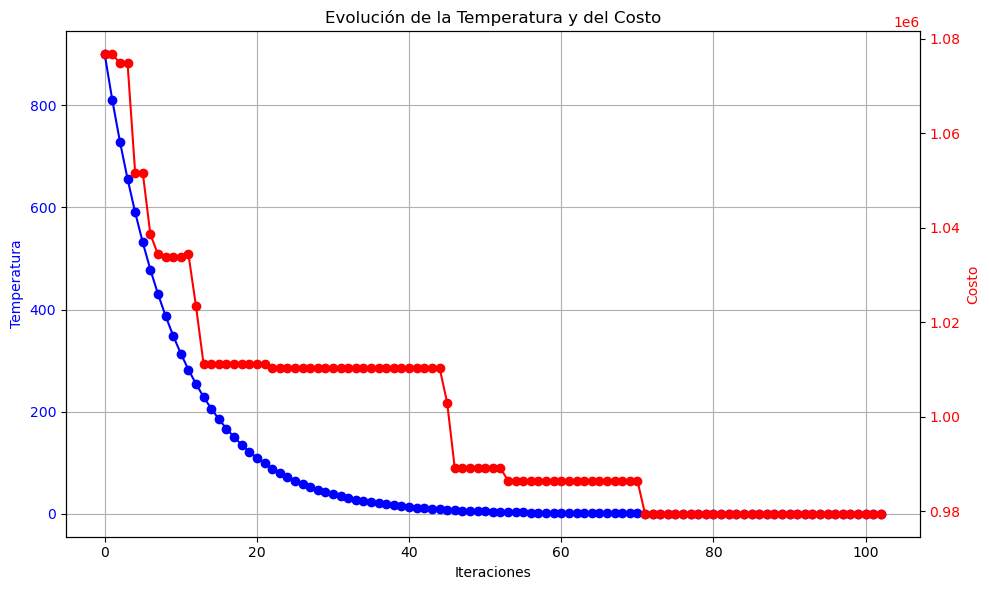

In [42]:
import matplotlib.pyplot as plt

# Ejemplo de listas de temperaturas y costos para graficar
# temperaturas = [t_0, t1, t2, ..., tn]
# costos = [costo_0, costo_1, costo_2, ..., costo_n]

# Crea la figura y el primer eje y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de la temperatura en el eje izquierdo
ax1.plot(temperaturas, color='blue', marker='o', linestyle='-', label='Temperatura')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Temperatura', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Crea el segundo eje y para los costos, compartiendo el mismo eje x
ax2 = ax1.twinx()
ax2.plot(costos, color='red', marker='o', linestyle='-', label='Costo')
ax2.set_ylabel('Costo', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Añade el título y muestra la gráfica
plt.title('Evolución de la Temperatura y del Costo')
fig.tight_layout()
plt.show()
